In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.style.use('seaborn')

%matplotlib inline

### Описание задачи

Возьмём датасет "200K SHORT TEXTS FOR HUMOR DETECTION". \
Ссылка на данные: https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection 

Наша задача, как можно понять из названия датасета - научиться классифицировать, содержит ли текст юмор.

In [27]:
dataset = pd.read_csv("dataset.csv")
dataset.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


Посмотрим на распределение длин текстов

In [4]:
lengths = np.array(dataset.text.apply(lambda text: len(text.split())))
np.unique(lengths)

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

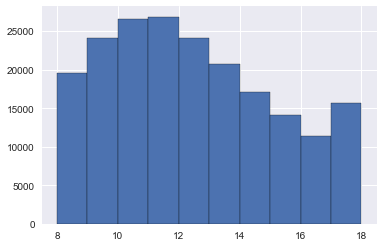

In [5]:
plt.hist(lengths, edgecolor='black');

Что ж, название датасета нас не обманывает - тексты и правда довольно короткие.

Немного посмотрим на данные. Какие слова чаще встречаются в текстах с юмором и без?

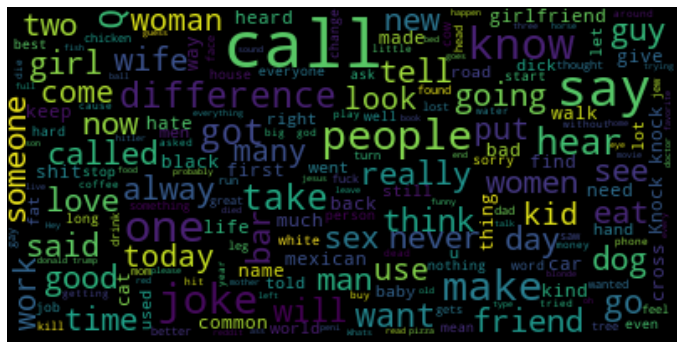

In [6]:
wordcloud = WordCloud(max_font_size=40, random_state=42).generate(" ".join(dataset[dataset.humor == True].text))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

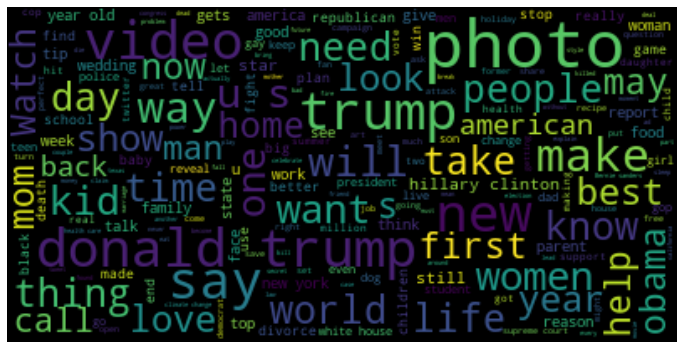

In [7]:
wordcloud = WordCloud(max_font_size=40, random_state=42).generate(" ".join(dataset[dataset.humor == False].text))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

На глаз сразу видны различия в облаках слов - можно ожидать, что и простой классификатор может нам дать неплохое качество на наших данных.

Попробуем обучить пару линейных моделей на TF-IDF признаках.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [30]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

### Линейный SVM + TF-IDF

In [10]:
tfidf = TfidfVectorizer()
tfidf.fit(train.text)

X_train, X_test = tfidf.transform(train.text), tfidf.transform(test.text)

svm = LinearSVC()
svm.fit(X_train, train.humor)

train_accuracy = (svm.predict(X_train) == train.humor).mean()
test_accuracy = (svm.predict(X_test) == test.humor).mean()

print(f"Train accuracy = {train_accuracy}, test accuracy = {test_accuracy}")

Train accuracy = 0.96613125, test accuracy = 0.92915


In [11]:
dataset.humor.mean()

0.5

Классы в данных сбалансированы, так что данное значение accuracy даёт нам основания считать, что это очень хорошее начало для решения нашей задачи

В шуточных текстах наверняка можно встретить не только отдельные специфические слова, но и словосочетания или N-граммы. Попробуем немного усложнить токенизацию в TF-IDF.

In [12]:
for n in range(2, 5):
    tfidf = TfidfVectorizer(ngram_range=(1, n))
    tfidf.fit(train.text)

    X_train, X_test = tfidf.transform(train.text), tfidf.transform(test.text)

    svm = LinearSVC()
    svm.fit(X_train, train.humor)

    train_accuracy = (svm.predict(X_train) == train.humor).mean()
    test_accuracy = (svm.predict(X_test) == test.humor).mean()

    print(f"N-Grams of size {n}: train accuracy = {train_accuracy}, test accuracy = {test_accuracy}")

N-Grams of size 2: train accuracy = 0.9990375, test accuracy = 0.947525
N-Grams of size 3: train accuracy = 0.99983125, test accuracy = 0.9413
N-Grams of size 4: train accuracy = 0.999925, test accuracy = 0.933075
N-Grams of size 5: train accuracy = 0.99995, test accuracy = 0.92615


Можно сделать вывод, что мы достаточным для модели будет рассматривать биграммы, а при больших N мы переобучаемся, что неудивительно, ведь тексты у нас короткие.

Потюним степень регуляризации классификатора - судя по разрыву между метриками на трейне и тесте, можно предположить, что мы немного переобучаемся на трейн.
Попробуем уменьшить гиперпараметр C, обратно пропорциональный степени ругеляризации в SVM (стандартное значение было равно 1.0).

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf.fit(train.text)

X_train, X_test = tfidf.transform(train.text), tfidf.transform(test.text)

grid = [0.5, 0.8, 1.5, 2.0]

for C in grid:
    svm = LinearSVC(C=C)
    svm.fit(X_train, train.humor)

    train_accuracy = (svm.predict(X_train) == train.humor).mean()
    test_accuracy = (svm.predict(X_test) == test.humor).mean()

    print(f"C={C}: train accuracy = {train_accuracy}, test accuracy = {test_accuracy}")

C=0.5: train accuracy = 0.99448125, test accuracy = 0.947075
C=0.8: train accuracy = 0.99809375, test accuracy = 0.947325
C=1.5: train accuracy = 0.999725, test accuracy = 0.947725
C=2.0: train accuracy = 0.99988125, test accuracy = 0.94765


Что ж, судя по всему, дело не в переобучении и даже наоборот, ослабление регуляризации помогло нам совсем немного лучше обучить классификатор.

### Catboost

Попробуем обучить градиентный бустинг на этих же данных.
Преимущество catboost заключается в том, что он может сразу работать на текстовых данных, строя внутри себя текстовые фичи на основе токенов.

In [29]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations=500, eval_metric='Accuracy')
cb.fit(train[['text']], train.humor.astype(int), text_features=['text'], plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
(cb_pred.astype(bool) == test.humor).mean()

0.9608

И мы получаем нового лидера на валидации!

### BiLSTM

Попробуем обучить для решения задачи небольшую рекуррентную нейросеть

In [59]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [102]:
import torchtext
from torchtext.vocab import vocab, build_vocab_from_iterator

import re
from string import punctuation
r = re.compile(r'[\s{}]+'.format(re.escape(punctuation)))

In [169]:
from collections import Counter, OrderedDict

counter = Counter()

In [170]:
def tokenize_text(text):
    tokens = r.split(text)
    tokens = [token.strip().lower() for token in tokens]
    tokens = [token for token in tokens if len(token) > 0]

    return tokens

for text in train.text:
    tokens = tokenize_text(text)
    counter.update(tokens)

In [171]:
len(counter)

57055

In [172]:
for word in stopwords.words('english'):
    if word in counter:
        del counter[word]

In [173]:
len(counter)

56905

In [165]:
counter.most_common(5)

[('like', 7320), ('call', 6876), ('trump', 6802), ('get', 5812), ('new', 5216)]

In [176]:
# уменьшим наш словарь для того, чтобы было проще обучить модель
counter = Counter({k: v for (k, v) in counter.items() if v >= 10})

In [177]:
len(counter)

12231

In [178]:
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

In [179]:
vocabulary = build_vocab_from_iterator([ordered_dict.keys()], specials=["<PAD>", "<UNK>", "<SOS>", "<EOS>"])
vocabulary.set_default_index(vocabulary["<UNK>"])

In [186]:
def generate_seq(text):
    tokens = tokenize_text(text)
    seq = list()
    for token in tokens:
        seq.append(vocabulary[token])
    return seq

In [199]:
class CorpusDataset(Dataset):
    def __init__(self, texts, targets):
        self.targets = torch.tensor(targets, dtype=torch.long)
        self.tokenized_texts = list()
        for i, text in enumerate(texts):
            self.tokenized_texts.append(
                torch.LongTensor(generate_seq(text))
            )
    
    def __getitem__(self, idx):
        return self.tokenized_texts[idx], self.targets[idx]
    
    def __len__(self):
        return len(self.tokenized_texts)

In [200]:
from torch.nn.utils.rnn import pad_sequence


class PaddingCollator:
    def __init__(self,  pad_token_id, batch_first=True):
        self.pad_token_idx = pad_token_id
        self.batch_first = batch_first

    def __call__(self, text_batch):
        new_texts = pad_sequence([pair[0] for pair in text_batch], padding_value=self.pad_token_idx, batch_first=self.batch_first)
        new_targets = torch.tensor([pair[1] for pair in text_batch])
        return new_texts, new_targets


In [312]:
ds = CorpusDataset(train.text, train.humor)
train_loader = DataLoader(
    ds,
    collate_fn=PaddingCollator(
        pad_token_id=vocabulary['<PAD>'],
        batch_first=True,
    ),
    batch_size=128
)

In [313]:
test_batch_size = 1024

test_ds = CorpusDataset(test.text, np.array(test.humor, dtype=int))
test_loader = DataLoader(
    test_ds,
    collate_fn=PaddingCollator(
        pad_token_id=vocabulary['<PAD>'],
        batch_first=True,
    ),
    batch_size=test_batch_size
)

In [314]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMModel(nn.Module):
    def __init__(self, voc_size, emb_size, hid_size):
        super().__init__()
        
        self.voc_size = voc_size
        self.emb_size = emb_size
        self.hid_size = hid_size

        self.embedding = nn.Embedding(voc_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hid_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2 * hid_size, 1)
    
    def forward(self, x):
        batch_size = x.shape[0]
        lengths = (x != vocabulary["<PAD>"]).sum(dim=1)
        x = self.embedding(x)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(x)
        h = h.permute(1, 0, 2).reshape(batch_size, 2 * self.hid_size)
        x = self.linear(h)
        return x

In [346]:
model = LSTMModel(len(vocabulary), emb_size=64, hid_size=64)

In [347]:
from torch.optim import Adam

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [348]:
def eval_accuracy(loader, data_size, model, threshold=0.5):
    
    scores = torch.zeros(data_size)
    targets = torch.zeros(data_size, dtype=int)

    i = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            targets[i:i + batch_y.shape[0]] = batch_y
            scores[i:i + batch_y.shape[0]] = model(batch_x).squeeze()
            i += batch_y.shape[0]
    
    return ((torch.sigmoid(scores) > threshold) == targets).float().mean()

In [349]:
from tqdm.notebook import tqdm

n_epochs = 10

for epoch in trange(n_epochs):
    
    for batch_x, batch_y in tqdm(train_loader):
        pred = model(batch_x).squeeze()
        batch_y = batch_y.float()

        optimizer.zero_grad()
                
        loss = criterion(pred, batch_y)
        
        print(f"Epoch #{epoch}: loss = {loss}", end='\r')
        
        loss.backward()
        optimizer.step()
    
    print(f"Train acc = {eval_accuracy(train_loader, len(train), model)}, test acc = {eval_accuracy(test_loader, len(test), model)}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.8983625173568726, test acc = 0.893625020980835


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9280812740325928, test acc = 0.916450023651123


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9428062438964844, test acc = 0.9256500005722046


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9510062336921692, test acc = 0.9279000163078308


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9569374918937683, test acc = 0.9278249740600586


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9620562791824341, test acc = 0.9259499907493591


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9660624861717224, test acc = 0.9244499802589417


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9690999984741211, test acc = 0.9208250045776367


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.970493733882904, test acc = 0.918749988079071


  0%|          | 0/1250 [00:00<?, ?it/s]

Train acc = 0.9739937782287598, test acc = 0.918749988079071


Данная архитектура, увы, не смогла побить на тесте даже линейный SVM, и судя по всему нужно либо улучшать процесс токенизации либо предобучать эмбеддинги.